***Méthodes numériques, PHYS-F302 (Module 5).***
*********************************
Stokes-flow in a square cavity.
==
### But #
Résoudre le système d'équation suivante:
\begin{equation}
\nabla^2 \omega = 0
\end{equation}

\begin{equation}
\nabla^2 \psi = -\omega
\end{equation} 
sans les découpler à l'aide des différentes méthodes itératives apprises dans ce module (itération de Jacobi, de Gauss-Seidel, SOR, Steepest Descent et Gradients conjugués).



## 1.Itération de Jacobi
On commence par cette méthode parce que c'est la plus simple à comprendre. On verra ensuite qu'elle est peu efficace et on la comparera aux autres méthodes.

In [1]:
from matplotlib import pyplot
import numpy
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [2]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

Fonction qui dessine en 3D:

In [3]:
def plot_3D(x, y, p):
    '''Creates 3D plot with appropriate limits and viewing angle
    
    Parameters:
    ----------
    x: array of float
        nodal coordinates in x
    y: array of float
        nodal coordinates in y
    p: 2D array of float
        calculated potential field
    
    '''
    fig = pyplot.figure(figsize=(11,7), dpi=100)
    ax = fig.gca(projection='3d')
    X,Y = numpy.meshgrid(x,y)
    surf = ax.plot_surface(X,Y,p[:], rstride=1, cstride=1, cmap=cm.viridis,
            linewidth=0, antialiased=False)

    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')
    ax.view_init(30,45)

Paramètres du problème:

In [4]:
nx = 41
ny = 41

l = 1.#length of the square in the x-direction 
h = 1.#length of the square in the y-direction

dx = l/(nx-1)
dy = h/(ny-1)

l1_target = 1e-6

Notre condition d'arrêt sera donnée en fonction de la norme L1 de la différence entre deux itérations successives:

In [5]:
def L1norm(new, old):
    norm = numpy.sqrt(numpy.sum((new - old)**2)/numpy.sum(old**2))
    return norm

Discrétisation des équations par la méthode de Jacobi:
\begin{equation}
\omega^{k+1}_{i,j} = \frac{1}{4} \left(\omega^{k}_{i,j-1} + \omega^k_{i,j+1} + \omega^{k}_{i-1,j} + \omega^k_{i+1,j} \right)
\end{equation}
(valable seulement pour $\Delta x= \Delta y$)
\begin{equation}
\psi_{i,j}^{k+1}=\frac{(\psi_{i+1,j}^{k}+\psi_{i-1,j}^{k})\Delta y^2+(\psi_{i,j+1}^{k}+\psi_{i,j-1}^{k})\Delta x^2+\omega_{i,j}^{k}\Delta x^2\Delta y^2}{2(\Delta x^2+\Delta y^2)}
\end{equation}


### Conditions au bord:
- $\psi$ est nul sur les quatres bords du carré
- $\omega$ est nul sur les bords sauf sur celui du haut:

Top:
$\frac{\partial \psi}{\partial y}=1$, $\nabla^2 \psi = -\omega$

=> $\omega_{i,j}=\frac{-1}{2\Delta y^{2}}\left(8\psi_{i,j-1}-\psi_{i,j-2}\right)-\frac{3}{\Delta y}$


In [6]:
def stokesjacobi(w,psi):
    '''Iteratively solves the Stokes flow equation using the Jacobi method
    
    Parameters:
    ----------
    w: 2D array of float
        Initial vorticity 
    psi: 2D array of floats
        Initial streamfunction
    Returns:
    -------
    w: Vorticity after relaxation
    psi: Streamfunction after relaxation
    '''
    
    l1norm_w = 1
    l1norm_psi=1
    wn= numpy.empty_like(w)
    psin=numpy.empty_like(psi)
    iterations=0
  
    while (l1norm_w>l1_target or l1norm_psi>l1_target) :
        
        wn = w.copy()
        psin=psi.copy()
        w[1:-1,1:-1] = .25 * (wn[1:-1,2:] + wn[1:-1, :-2] \
                              + wn[2:, 1:-1] + wn[:-2, 1:-1])
        
        
        psi[1:-1,1:-1] = 1/(2*(dx**2 + dy**2)) * \
                        ((psin[1:-1,2:]+psin[1:-1,:-2])*dy**2 +\
                        (psin[2:,1:-1] + psin[:-2,1:-1])*dx**2 +\
                         wn[1:-1,1:-1]*dx**2*dy**2)
            
        ##B.C on the top of the square
        w[1:-1,-1]=(-1/(dy)**2)*(8*psi[1:-1,-2]-psi[1:-1,-3])-3.0/dy
        
        l1norm_w=L1norm(w,wn)
        
        if numpy.sum(psin**2) != 0 : # éviter la division par zéro pour psi uniformément nul
            
            l1norm_psi=L1norm(psi,psin)
        
    
        iterations += 1 
        
        
        
    print(iterations,l1norm_w,l1norm_psi)
    return psi

In [7]:
x = numpy.linspace(0,1,nx)
y = numpy.linspace(0,1,ny)

w=numpy.zeros((nx,ny))
psi=numpy.zeros((nx,ny))
w[1:-1,-1]=-3/dy

psi= stokesjacobi(w.copy(),psi.copy())

2463 1.73256114926e-07 9.9815291293e-07


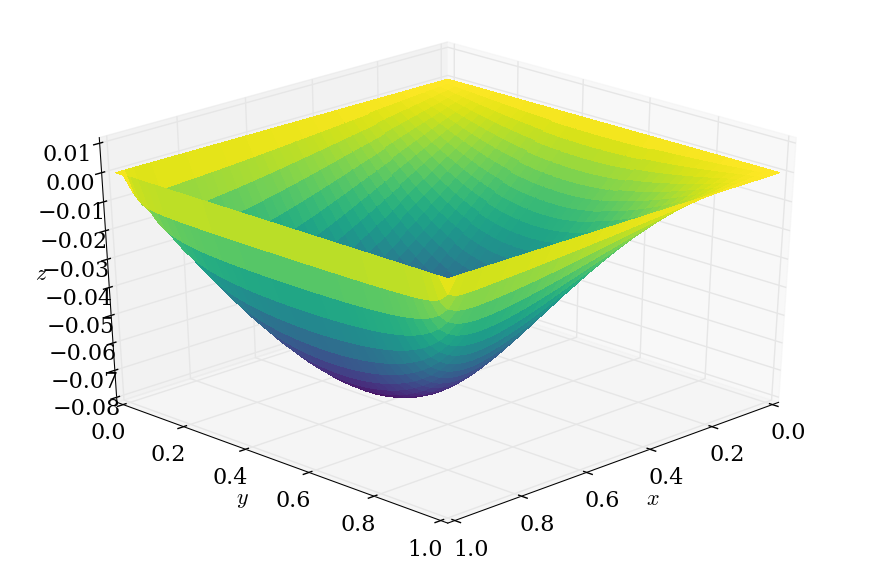

In [8]:
plot_3D(x,y,psi)

In [9]:
import numba
from numba import jit

In [ ]:

@jit(nopython=True)
def stokesGauss(w,psi):
    '''Iteratively solves the Stokes flow equation using the Jacobi method
    
    Parameters:
    ----------
    w: 2D array of float
        Initial vorticity 
    psi: 2D array of floats
        Initial streamfunction
    Returns:
    -------
    w: Vorticity after relaxation
    psi: Streamfunction after relaxation
    '''
    
    l1norm_w = 1
    l1norm_psi=1
    wn = numpy.empty_like(w)
    psin=numpy.empty_like(psi)
    iterations=0
    den_w=0
    den_psi=0
    
  
    while (l1norm_psi>l1_target or l1norm_w>l1_target):
        
        for j in range(ny):
            for i in range(nx):
                wn[j,i] = w[j,i]
                psin[j,i] = psi[j,i]
                
    
        for j in range(1,ny-1):
            for i in range(1,nx-1):
                w[j,i] = .25 * (wn[j,i+1] + wn[j,i-1] \
                              + wn[j+1,i] + wn[j-1,i])
        
       
                psi[j,i] = 1/(2*(dx**2 + dy**2)) * \
                        ((psin[j,i+1]+psin[j,i-1])*dy**2 +\
                        (psin[j+1,i] + psin[j-1,i])*dx**2 +\
                         wn[j,i]*dx**2*dy**2)
            
        ##B.C on the top of the square
        for j in range(ny):
            w[j,-1]=(-1/(dy)**2)*(8*psi[j,-2]-psi[j,-3])-3.0/dy
            
        for j in range(ny):
            for i in range(nx):
                l1norm_w += (w[j,i] - wn[j,i])**2
                den_w += (wn[j,i]*wn[j,i])
                l1norm_psi += (psi[j,i] - psin[j,i])**2
                den_psi += (psin[j,i]*psin[j,i])
        
        l1orm_w = (l1norm_w/den_w)**0.5
        
        if den_psi != 0 : # éviter la division par zéro pour psi uniformément nul
            l1norm_psi = (l1norm_psi/den_psi)**0.5
        
    
        iterations += 1 
        
    
        
    print(iterations,l1norm_w,l1norm_psi)
    return psi

In [ ]:
x = numpy.linspace(0,1,nx)
y = numpy.linspace(0,1,ny)

w=numpy.zeros((nx,ny))
psi=numpy.zeros((nx,ny))
w[1:-1,-1]=-3/dy

psi= stokesGauss(w.copy(),psi.copy())

In [ ]:
plot_3D(x,y,psi)